# Regularization and the bias-variance trade-off

**Overfitting** is a constant danger with machine learning models. Overfit models fit the training data well. However, an overfit model will not **generalize**. A model that generalizes is a model which exhibits good performance on data cases beyond the ones used in training. Models that generalize will be useful in production. 

As a general rule, an overfit model has learned the training data too well. The overfitting likely involved learning noise present in the training data. The noise in the data is random and uninformative. When a new data case is presented to such a model it may produce unexpected results since the random noise will be different. 

So, what is one to do to prevent overfitting of machine learning models? The most widely used set of tools for preventing overfitting are known as **regularization methods**. Regularization methods take a number of forms, but all have the same goal, to prevent overfitting of machine learning models. 

Regularization is not free however. While regularization reduces the **variance** in the model results, it introduces **bias**. Whereas, an overfit model exhibits low bias the variance is high. The high variance leads to unpredictable results when the model is exposed to new data cases. On the other hand, the stronger the regularization of a model the lower the variance, but the greater the bias. This all means that when applying regularization you will need to contend with the **bias-variance trade-off**. 

To better understand the bias variance trade-off consider the following examples of extreme model cases:

- If the prediction for all cases is just the mean (or median), variance is minimized. The estimate for all cases is the same, so the bias of the estimates is zero. However, there is likely considerable variance in these estimates. 
- On the other hand, consider what happens when the data are fit with a kNN model with k=1. The training data will fit this model perfectly, since there is one model coefficient per training data point. The variance will be low. However, the model will have considerable bias when applied to test data. 

In either case, these extreme models will not generalize well and will exhibit large errors on any independent test data. Any practical model must come to terms with the trade-off between bias and variance to make accurate predictions. 

To better understand this trade-off you can consider the example of the mean square error, which can be decomposed into its components. The mean square error can be written as:

$$\Delta x = E \Big[ \big(Y - \hat{f}(X) \big)^2 \Big] = \frac{1}{N} \sum_{i=1}^N \big(y_i - \hat{f}(x_i) \big)^2 $$

Where,
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Expanding the representation of the mean square error:

$$\Delta x = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta x = Bias^2 + Variance + Irreducible\ Error$$

Study this relationship. Notice that as regularization reduces variance, bias increases. The irreducible error will remain unchanged. Regularization parameters are chosen to minimize $\Delta x$. In many cases, this will prove challenging. 

## Load a  data set

With the above bit of theory in mind, it is time to try an example. In this example you will compute and compare linear regression models using different levels and types of regularization. 

Execute the code in the cell below to load the packages required for the rest of this notebook.

In [1]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

data_dir = './datasets/'

%matplotlib inline

The data are available in a pre-processed form. The preprocessing includes the following:
1. Cleaning missing values.
2. Aggregate categories of certain categorical variables. 
3. Encoding categorical variables as binary dummy variables.
4. Standardization of numeric variables. 

Execute the code in the cell below to load the features and labels as numpy arrays for the example. 

In [2]:
Features = np.array(pd.read_csv(data_dir+'Auto_Data_Features.csv'))
Labels = np.array(pd.read_csv(data_dir+'Auto_Data_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(195, 45)
(195, 1)


Notice that there are 195 cases and a total of 45 features. 

## Split the dataset

With the feature array loaded, you must now create randomly sampled training and test data sets. The code in the cell below uses the `train_test_split` function from the `sklearn.model_selection` module to Bernoulli sample the cases in the original dataset into the two subsets. Since this data set is small only 40 cases will be included in the test dataset. Execute this code. 

In [3]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 40)

x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## A first linear regression model

To create a baseline for comparison, you will first create a model using all 45 features and no regularization. In the terminology used before this model has high variance and low bias. In otherwords, this model is overfit. 

The code in the cell below should be familiar. In summary, it performs the following processing:
1. Define and train the linear regression model using the training features and labels.
2. Score the model using the test feature set. 
3. Compute and display key performance metrics for the model using the test feature set. 
4. Plot a histogram of the residuals of the model using the test partition.
5. Plot a Q-Q Normal plot of the residuals of the model using the test partition.
6. Plot the residuals of the model vs. the predicted values using the test partition. 

Execute this code and examine the results for the linear regression model. 

Mean Square Error      = 0.02103483180293406
Root Mean Square Error = 0.14503389880622414
Mean Absolute Error    = 0.11896679673181176
Median Absolute Error  = 0.09769580826160063
R^2                    = 0.927117834599049


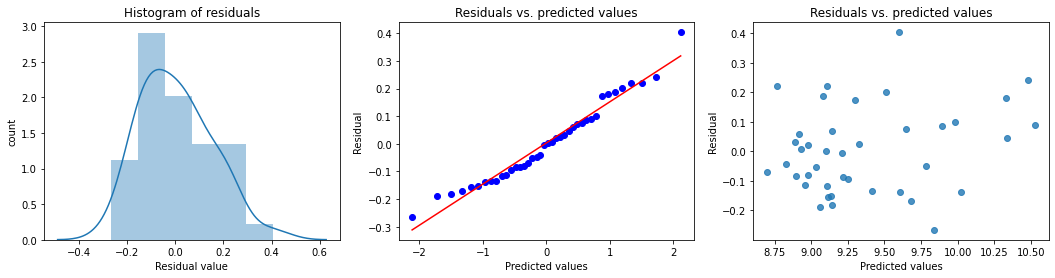

In [4]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x_train, y_train)

def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    
def resid_plot(y_test, y_score, ax=None):
    if not ax:
        fig, ax= plt.subplots(1,1, figsize=(6,4))
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False, ax=ax)
    ax.set_title('Residuals vs. predicted values')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residual')
    #ax.show()

def hist_resids(y_test, y_score, ax=None):
    
    if not ax:
        fig, ax= plt.subplots(1,1, figsize=(6,4))
        
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids, ax=ax)
    ax.set_title('Histogram of residuals')
    ax.set_xlabel('Residual value')
    ax.set_ylabel('count')
    #plt.show()
    
def resid_qq(y_test, y_score, ax=None):
    if not ax:
        fig, ax= plt.subplots(1,1, figsize=(6,4))
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = ax)
    ax.set_title('Residuals vs. predicted values')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residual')
    #ax.show()
 
fig,ax=plt.subplots(1,3, figsize=(18,4))

y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score) 
hist_resids(y_test, y_score, ax=ax[0])  
resid_qq(y_test, y_score, ax=ax[1]) 
resid_plot(y_test, y_score, ax=ax[2]) 
plt.show()

Overall these results are reasonably good. The error metrics are relatively small. Further, the distribution of the residuals is a bit skewed, but otherwise well behaved. 

## Apply l2 regularization

Now, you will apply **l2 regularization** to constrains the model parameters. Constraining the model parameters prevent overfitting of the model. This method is also known as **Ridge Regression**. 

But, how does this work? l2 regularization applies a **penalty** proportional to the **l2** or **Eucldian norm** of the model weights to the loss function. For linear regression using squared error as the metric, the total **loss function** is the sum of the squared error and the regularization term. The total loss function can then be written as follows:  

$$J(\beta) = ||A \beta + b||^2 + \lambda ||\beta||^2$$

Where the penalty term on the model coefficients, $\beta_i$, is written:

$$\lambda || \beta||^2 = \lambda \big(\beta_1^2 + \beta_2^2 + \ldots + \beta_n^2 \big)^{\frac{1}{2}} = \lambda \Big( \sum_{i=1}^n \beta_i^2 \Big)^{\frac{1}{2}}$$

We call $||\beta||^2$ the **l2 norm** of the coefficients, since we raise the weights of each coefficient to the power of 2, sum the squares and then raise the sum to the power of $\frac{1}{2}$. 

You can think of this penalty as constraining the 12 or Euclidean norm of the model weight vector. The value of $\lambda$ determines how much the norm of the coefficient vector constrains the solution. You can see a geometric interpretation of the l2 penalty constraint in the figure below.  

<img src="./images/L2.jpg" alt="Drawing" style="width:750px; height:400px"/>
<center> **Geometric view of l2 regularization**

Notice that for a constant value of the l2 norm, the values of the model parameters $B_1$ and $B_2$ are related. The Euclidian or l2 norm of the coefficients is shown as the dotted circle. The constant value of the l2 norm is a constant value of the penalty. Along this circle the coefficients change in relation to each other to maintain a constant l2 norm. For example, if $B_1$ is maximized then $B_2 \sim 0$, or vice versa. It is important to note that l2 regularization is a **soft constraint**. Coefficients are driven close to, but likely not exactly to, zero.    

With this bit of theory in mind, it is time to try an example of l2 regularization. The code in the cell below computes the linear regression model over a grid of 100 l2 penalty values. In a bit more detail, this code performs the following  processing:
1. A grid of approximately 100 l2 penalty parameters is created.
2. A function is called which loops over the list of l2 penalty parameters. For each iteration, a penalized l2 regression model is computed along with the root mean squared error which is saved in a list. The `Ridge` function from the scikit-learn `Linear_model` package is used to define the l2 regularized linear regression model. The value of the reqularization parameter is which achieved the lowest RMSE is saved. 
3. A function is called which creates two plots: One of RMSE vs regularization parameter, and, one of the values of the regression coefficients vs. the regularization parameter.

Execute this code and examine the results. 

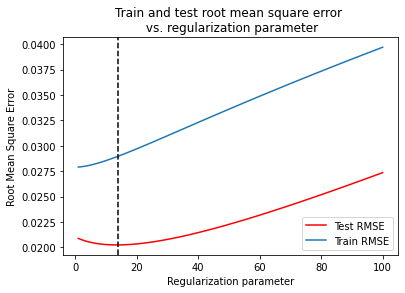

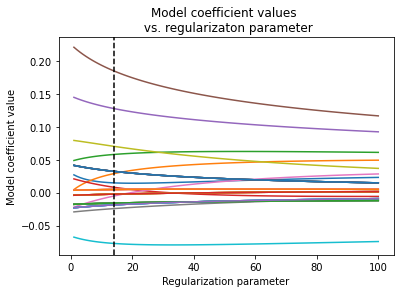

(14, 0.020249281682184834)


In [5]:
def plot_regularization(l, train_RMSE, test_RMSE, coefs, min_idx, title):   
    plt.plot(l, test_RMSE, color = 'red', label = 'Test RMSE')
    plt.plot(l, train_RMSE, label = 'Train RMSE')    
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.legend()
    plt.xlabel('Regularization parameter')
    plt.ylabel('Root Mean Square Error')
    plt.title(title)
    plt.show()
    
    plt.plot(l, coefs)
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.title('Model coefficient values \n vs. regularizaton parameter')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Model coefficient value')
    plt.show()

def test_regularization_l2(x_train, y_train, x_test, y_test, l2):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l2:
        lin_mod = linear_model.Ridge(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(sklm.mean_squared_error(y_train, y_score_train))
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(sklm.mean_squared_error(y_test, y_score))
    min_idx = np.argmin(test_RMSE)
    min_l2 = l2[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l2, train_RMSE, test_RMSE, coefs, min_l2, title)
    return min_l2, min_RMSE
     
l2 = [x for x in range(1,101)]
out_l2 = test_regularization_l2(x_train, y_train, x_test, y_test, l2)
print(out_l2)

Examine these results.

The top plot shows the training and test RMSE vs the regularization parameter. The point with the minimum RMSE is shown with a dotted line. Notice that there is a minimum where the l2 parameter has a value of 14.0. To the left of the minimum variance dominates bias. To the right of the minimum bias dominates variance. In this case, the changes in RMSE are not dramatic until the bias grows significantly.  

The bottom plot shows the value of the 45 model coefficients vs. the regularization parameter. At the left the regularization penalty is small and the coefficient values show a wide range of values, giving a high variance model. To the right the coefficient values become more tightly clustered, giving a more constrained and higher bias model. 

Next, you will evaluate the model using the best l2 regularization parameter discovered above. The code in the cell below computes the regression model with the training data and computes and displays the results using the test data. 

Execute the code, and then answer **Question 1** on the course page.

Mean Square Error      = 0.020249281682184834
Root Mean Square Error = 0.14229997077366122
Mean Absolute Error    = 0.11685808644799409
Median Absolute Error  = 0.11642918023953719
R^2                    = 0.9298396340585149


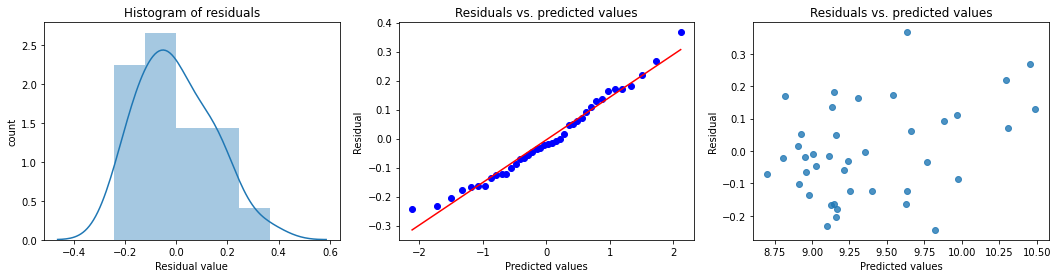

In [6]:
lin_mod_l2 = linear_model.Ridge(alpha = out_l2[0])
lin_mod_l2.fit(x_train, y_train)
y_score_l2 = lin_mod_l2.predict(x_test)

fig,ax=plt.subplots(1,3, figsize=(18,4))

print_metrics(y_test, y_score_l2)
hist_resids(y_test, y_score_l2, ax=ax[0])  
resid_qq(y_test, y_score_l2, ax=ax[1]) 
resid_plot(y_test, y_score_l2, ax=ax[2]) 

Compare the error metrics achieved to those of the un-regularized model. The error metrics for the regularized model are somewhat better. This fact, indicates that the regularized model generalizes better than the unregularized model. Notice also that the residuals are a bit closer to Normally distributed than for the unregularized model. 

## Apply l1 regularizaton

Regularization can be performed using norms other than l2. The **l1 regularizaton** or **Lasso**  method limits the sum of the absolute values of the model coefficients. The l1 norm is sometime know as the **Manhattan norm**, since distance are measured as if you were traveling on a rectangular grid of streets. This is in contrast to the l2 norm that measures distance 'as the crow flies'. 

We can compute the l1 norm of the model coefficients as follows:

$$||\beta||^1 = \big( |\beta_1| + |\beta_2| + \ldots + |\beta_n| \big) = \Big( \sum_{i=1}^n |\beta_i| \Big)^1$$

where $|\beta_i|$ is the absolute value of $\beta_i$. 

Notice that to compute the l1 norm, we raise the sum of the absolute values to the first power.

As with l2 regularization, for l1 regularization, a penalty term is multiplied by the l1 norm of the model coefficients. A penalty multiplier, $\lambda$, determines how much the norm of the coefficient vector constrains values of the weights. The complete loss function is the sum of the squared errors plus the penalty term which becomes: 

$$J(\beta) = ||A \beta + b||^2 + \lambda ||\beta||^1$$

You can see a geometric interpretation of the l1 norm penalty in the figure below.  

<img src="./images/L1.jpg" alt="Drawing" style="width:700px; height:400px"/>
<center> **Geometric view of L1 regularization**

The l1 norm is constrained by the sum of the absolute values of the coefficients. This fact means that values of one parameter highly constrain another parameter. The dotted line in the figure above looks as though someone has pulled a rope or lasso around pegs on the axes. This behavior leads the name lasso for l1 regularization.  

Notice that in the figure above that if $B_1 = 0$ then $B_2$ has a value at the limit, or vice versa. In other words, using a l1 norm constraint forces some weight values to zero to allow other coefficients to take non-zero values. Thus, you can think of the l1 norm constraint **knocking out** some weights free the model altogether. In contrast to l2 regularization, l1 regularization does drive some coefficients to exactly zero.

The code in the cell below computes l1 regularized or lasso regression over a grid of regularization values. The structure of the code is nearly the same as for the l2 example. The `Lasso` function from the scikit-learn `Linear_model` package is used to define the l1 regularized linear regression model.

Execute the code and examine the results.

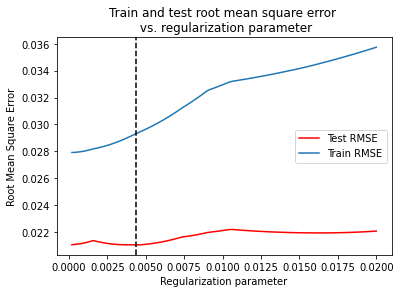

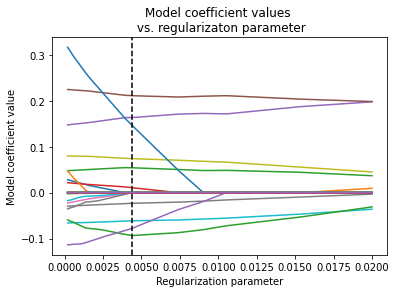

(0.0044, 0.02101807877979179)


In [7]:
def test_regularization_l1(x_train, y_train, x_test, y_test, l1):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l1:
        lin_mod = linear_model.Lasso(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(sklm.mean_squared_error(y_train, y_score_train))
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(sklm.mean_squared_error(y_test, y_score))
    min_idx = np.argmin(test_RMSE)
    min_l1 = l1[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l1, train_RMSE, test_RMSE, coefs, min_l1, title)
    return min_l1, min_RMSE
    
l1 = [x/5000 for x in range(1,101)]
out_l1 = test_regularization_l1(x_train, y_train, x_test, y_test, l1)
print(out_l1)

As before, the top plot shows the training and test RMSE vs the regularization parameter. The point with the minimum RMSE is shown with a dotted line. Notice that there is a minimum where the l1 parameter has a value of 0.0044. To the left of the minimum variance dominates bias. To the right of the minimum bias dominates variance. Notice that the curve of RMSE has some kinks or sharp bends. This is in contrast to the smooth curve produced by l2 regularization. 

The bottom plot shows the value of the 45 model coefficients vs. the regularization parameter. At the left the regularization penalty is small and the coefficient values show a wide range of values, giving a high variance model. To the right the coefficient values become more tightly clustered, giving a more constrained and higher bias model. In addition, many of the parameters are being driven to zero as the regularization parameter increases. The parameters being driven to zero account for the kinks in the RMSE curve.   

The code in the cell below computes the l1 regularized regression model with the training data and computes and displays the results using the test data. Execute the code. Execute this code, evaluate the results, and answer **Question 2** on the course page. 

Mean Square Error      = 0.02101807877979179
Root Mean Square Error = 0.1449761317589616
Mean Absolute Error    = 0.11890258840732537
Median Absolute Error  = 0.1101290249507727
R^2                    = 0.9271758810153483


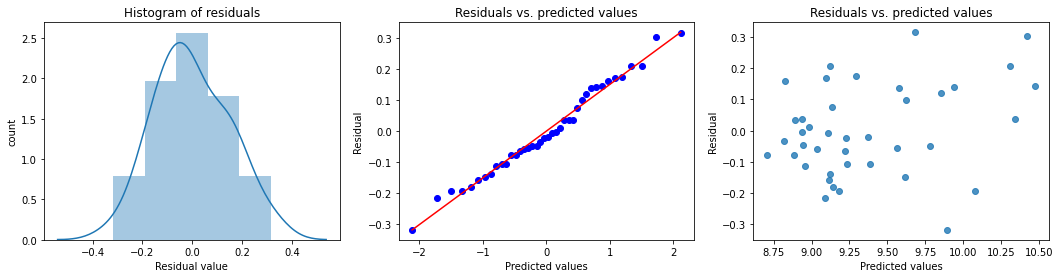

In [8]:
lin_mod_l1 = linear_model.Lasso(alpha = out_l1[0])
lin_mod_l1.fit(x_train, y_train)
y_score_l1 = lin_mod_l1.predict(x_test)


fig,ax=plt.subplots(1,3, figsize=(18,4))

print_metrics(y_test, y_score_l1) 
hist_resids(y_test, y_score_l1, ax=ax[0])  
resid_qq(y_test, y_score_l1, ax=ax[1]) 
resid_plot(y_test, y_score_l1, ax=ax[2]) 

Compare the performance metrics of the 11 regularized model to the metrics for the un-regularized model and the l2 regularized model. In this case the error metrics are in between the two previous models. The residuals are closer to the unregularized model. 

## Summary

In this lab you have explored the basics of regularization. Regularization can prevent machine learning models from being overfit. Regularization is required to help machine learning models generalize when placed in production. Selection of regularization strength involves consideration of the bias-variance trade-off. 

L2 and l1 regularization constrain model coefficients to prevent overfitting. L2 regularization constrains model coefficients using a Euclidian norm. L2 regularization can drive some coefficients toward zero, usually not to zero. On the other hand, l1 regularization can drive model coefficients to zero. 